In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
import numpy as np
import math
import torch
from torch import nn

import pandas as pd

from datetime import datetime

from torch.utils.data import Dataset

from Models import get_mlp, BigGenerator, MeanFieldVariationalDistribution, GaussianProcess
from Tools import AverageNormalLogLikelihood, logmvn01pdf
from Metrics import KL, evaluate_metrics, Entropy

from Experiments import get_setup

from Inference.IVI_noise import IVI

from tqdm import trange

import timeit

In [3]:
torch.manual_seed(42)
## Hyperparameters ##

#predictive model
layerwidth=50
nblayers=1
activation=nn.ReLU()

#generative model
lat_dim=5

#optimizer
learning_rate=0.005

#scheduler
patience=30
lr_decay=.7#.7
min_lr= 0.0001
n_epochs=2000#5000#2000


#loss hyperparameters
n_samples_LL=100 #nb of predictor samples for average LogLikelihood

n_samples_KL=500 #nb of predictor samples for KL divergence
kNNE=1 #k-nearest neighbour

batch_size=100

sigma_prior=.5# TO DO check with other experiments setup.sigma_prior    


input_sampling='uniform' #'uniform', 'uniform+data'


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [5]:
def get_metrics(y_pred, sigma_noise, y_test, std_y_train, method, time):
    metrics=evaluate_metrics(y_pred, sigma_noise.view(1,1,1), y_test,  std_y_train, device='cpu', std=False)
    metrics.update({'time [s]': time})
    metrics.update({'std noise': sigma_noise.item()})
    metrics_list=list(metrics.keys())
    for j in metrics_list:
        metrics[(method,j)] = metrics.pop(j)
    return metrics

def FuNNeVI_noise(dataset,device):

    setup_ = get_setup(dataset)
    setup=setup_.Setup(device, seed=117) 

    x_train, y_train=setup.train_data()
    x_test, y_test=setup.test_data()

    std_y_train = torch.tensor(1.)
    if hasattr(setup, '_scaler_y'):
        std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    size_data=len(train_dataset)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    ## predictive model
    input_dim=x_train.shape[1]
    param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation)
    
    def prior(n):
        return sigma_prior*torch.randn(size=(n,param_count), device=device)
    

    if input_sampling=='mixture':
        def input_sampler(x_data):
            n_ood=1
            M = x_train.max(0, keepdim=True)[0]
            m = x_train.min(0, keepdim=True)[0]
            X_rand = torch.rand(n_ood,input_dim).to(device) * (M-m) + m                            
            X=torch.cat([x_data,\
                         x_data+0.1*torch.randn_like(x_data),\
                         x_data+0.1*torch.randn_like(x_data),\
                         x_data+0.1*torch.randn_like(x_data),
                         X_rand])   
            return X
    
    if input_sampling=='uniform':
        def input_sampler(x_data):
            n_ood=200
            M = x_train.max(0, keepdim=True)[0]
            m = x_train.min(0, keepdim=True)[0]
            X = torch.rand(n_ood,input_dim).to(device) * (M-m) + m                           
            return X
    
    if input_sampling=='uniform+data':
        def input_sampler(x_data):
            n_ood=150
            M = x_train.max(0, keepdim=True)[0]
            m = x_train.min(0, keepdim=True)[0]
            X_rand = torch.rand(n_ood,input_dim).to(device) * (M-m) + m   
            X=torch.cat([X_rand,x_data])
            return X
    
    def projection(theta0,theta1, x_data):
        X=input_sampler(x_data)
        #compute projection on both paramters with model
        theta0_proj=model(X, theta0).squeeze(2)
        theta1_proj=model(X, theta1).squeeze(2)
        return theta0_proj, theta1_proj

    def kl(x_data, GeN):

        theta=GeN(n_samples_KL) #variationnel
        theta_prior=prior(n_samples_KL) #prior

        theta_proj, theta_prior_proj = projection(theta, theta_prior,x_data)

        K=KL(theta_proj, theta_prior_proj,k=kNNE,device=device)
        return K
    
    
    
    def ELBO(x_data, y_data, GeN, _sigma_noise):
        y_pred=model(x_data,GeN(n_samples_LL))
        sigma_noise = torch.log(torch.exp(_sigma_noise) + 1.)

        Average_LogLikelihood=AverageNormalLogLikelihood(y_pred, y_data, sigma_noise)
        the_KL=kl(x_data, GeN)
        the_ELBO= - Average_LogLikelihood+ (len(x_data)/size_data)* the_KL
        return the_ELBO, the_KL, Average_LogLikelihood, sigma_noise

    #generative model
    GeN = BigGenerator(lat_dim,param_count,device).to(device)

    ## Parametrize noise for learning aleatoric uncertainty
    
    _sigma_noise=torch.log(torch.tensor(1.).exp()-1.).clone().to(device).detach().requires_grad_(True)
    sigma_noise = torch.log(torch.exp(_sigma_noise) + 1.)

    optimizer = torch.optim.Adam(list(GeN.parameters())+[_sigma_noise], lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay, min_lr=min_lr)

    Run=IVI(train_loader, ELBO, optimizer)
    
    start = timeit.default_timer()
    with trange(n_epochs) as tr:
        tr.set_description(desc=dataset+'/FuNNeVI', refresh=False)
        for t in tr:
            
            
            scores=Run.run(GeN,_sigma_noise)

            scheduler.step(scores['ELBO'])
            tr.set_postfix(ELBO=scores['ELBO'], LogLike=scores['LL'], KL=scores['KL'], lr=scores['lr'], sigma=scores['sigma'])

            if scores['lr'] <= 1e-4:
                break
    stop = timeit.default_timer()
    time = stop - start
    
    theta=GeN(1000).detach()
    sigma_noise = torch.log(torch.exp(_sigma_noise) + 1.).detach().cpu()
    y_pred=model(x_test,theta)
    metrics=get_metrics(y_pred, sigma_noise, y_test, std_y_train, 'FuNNeVI', time)
    return metrics, GeN, sigma_noise


def GeNNeVI_noise(dataset,device):

    setup_ = get_setup(dataset)
    setup=setup_.Setup(device, seed=42) 

    x_train, y_train=setup.train_data()
    x_test, y_test=setup.test_data()

    std_y_train = torch.tensor(1.)
    if hasattr(setup, '_scaler_y'):
        std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()
    
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    size_data=len(train_dataset)


    ## predictive model
    input_dim=x_train.shape[1]
    param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation)
    
    def prior(n):
        return sigma_prior*torch.randn(size=(n,param_count), device=device)
    
    def kl(x_data, GeN):

        theta=GeN(n_samples_KL) #variationnel
        theta_prior=prior(n_samples_KL) #prior

        K=KL(theta, theta_prior,k=kNNE,device=device)
        return K
    
    def ELBO(x_data, y_data, GeN, _sigma_noise):
        alpha=(len(x_data)/size_data) #TODO check with alpah=1.
        y_pred=model(x_data,GeN(n_samples_LL))
        sigma_noise = torch.log(torch.exp(_sigma_noise) + 1.)

        Average_LogLikelihood=AverageNormalLogLikelihood(y_pred, y_data, sigma_noise)
        the_KL=kl(x_data, GeN)
        the_ELBO= - Average_LogLikelihood+ alpha* the_KL#(len(x_data)/size_data)*the_KL
        return the_ELBO, the_KL, Average_LogLikelihood, sigma_noise

    #generative model
    GeN = BigGenerator(lat_dim,param_count,device).to(device)

    ## Parametrize noise for learning aleatoric uncertainty
    
    _sigma_noise=torch.log(torch.tensor(1.0).exp()-1.).clone().to(device).detach().requires_grad_(True)
    sigma_noise = torch.log(torch.exp(_sigma_noise) + 1.)

    optimizer = torch.optim.Adam(list(GeN.parameters())+[_sigma_noise], lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay, verbose=True, min_lr=min_lr)

    Run=IVI(train_loader, ELBO, optimizer)
    
    start = timeit.default_timer()
    with trange(n_epochs) as tr:
        tr.set_description(desc=dataset+'/GeNNeVI', refresh=False)
        for t in tr:

            
            scores=Run.run(GeN,_sigma_noise)

            scheduler.step(scores['ELBO'])
            tr.set_postfix(ELBO=scores['ELBO'], LogLike=scores['LL'], KL=scores['KL'], lr=scores['lr'], sigma=scores['sigma'])

            if scores['lr'] <= 1e-4:
                break
    stop = timeit.default_timer()
    time = stop - start
    
    theta=GeN(1000).detach()
    sigma_noise = torch.log(torch.exp(_sigma_noise) + 1.).detach().cpu()
    y_pred=model(x_test,theta)
    metrics=get_metrics(y_pred, sigma_noise, y_test, std_y_train, 'GeNNeVI', time)
    return metrics, GeN, sigma_noise


In [6]:
dataset='boston'
setup_ = get_setup(dataset)
setup=setup_.Setup(device, seed=42) 

x_train, y_train=setup.train_data()
x_test, y_test=setup.test_data()


def ood_input(n_ood=50):
    M = x_train.max(0, keepdim=True)[0]
    m = x_train.min(0, keepdim=True)[0]
    X_rand = torch.rand(n_ood,input_dim).to(device) * (M-m) + m  
    return X_rand 

def noisy_train(n_ood=50):
    return x_train[:n_ood]+0.1*torch.randn_like(x_train[:n_ood])

input_dim=x_train.shape[1]
param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation)

In [ ]:

metrics_FuN, GeN_FuN, sigma_noise_FuN=FuNNeVI_noise(dataset,device)


boston/FuNNeVI:   3%|▎         | 55/2000 [00:03<02:06, 15.37it/s, ELBO=53.8, KL=131, LogLike=-26.5, lr=0.005, sigma=0.361] 

In [ ]:
metrics_GeN, GeN_GeN, sigma_noise_GeN=GeNNeVI_noise(dataset,device)


In [8]:
#metrics_GeN,
metrics_FuN 

{('FuNNeVI', 'RMSE'): 4.071767807006836,
 ('FuNNeVI', 'LPP'): -9.66869068145752,
 ('FuNNeVI', 'gLPP'): -13.272120475769043,
 ('FuNNeVI', 'WAIC'): -199852.30931568146,
 ('FuNNeVI', 'PICP'): 0.5098039507865906,
 ('FuNNeVI', 'MPIW'): 7.296823978424072,
 ('FuNNeVI', 'time [s]'): 110.53696448495612,
 ('FuNNeVI', 'std noise'): 0.08605139702558517}

In [ ]:
{('FuNNeVI', 'RMSE'): 4.071767807006836,
 ('FuNNeVI', 'LPP'): -9.66869068145752,
 ('FuNNeVI', 'gLPP'): -13.272120475769043,
 ('FuNNeVI', 'WAIC'): -199852.30931568146,
 ('FuNNeVI', 'PICP'): 0.5098039507865906,
 ('FuNNeVI', 'MPIW'): 7.296823978424072,
 ('FuNNeVI', 'time [s]'): 109.94359238119796,
 ('FuNNeVI', 'std noise'): 0.08605139702558517}

In [66]:
setup_ = get_setup(dataset)
setup=setup_.Setup(device, seed=42) 

In [67]:
models_HMC = torch.load('Results/HMC_models.pt')
theta_HMC=models_HMC[dataset][:500,:].to(device)
pred_HMC = model(x_test,theta_HMC)
sigma_noise=torch.tensor(setup.sigma_noise)
std_y_train = torch.tensor(1.)
if hasattr(setup, '_scaler_y'):
    std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()
    
metrics_HMC=get_metrics(pred_HMC, sigma_noise, y_test, std_y_train, 'HMC', 0.)
metrics_HMC

{('HMC', 'RMSE'): 2.5727829933166504,
 ('HMC', 'LPP'): -4.112078666687012,
 ('HMC', 'gLPP'): -4.112323760986328,
 ('HMC', 'WAIC'): -4.118648516014218,
 ('HMC', 'PICP'): 1.0,
 ('HMC', 'MPIW'): 95.9173583984375,
 ('HMC', 'time [s]'): 0.0,
 ('HMC', 'std noise'): 2.5}

Text(0.5, 0.98, 'Posterior Predictive on test (HMC, RMSE: 2.572783, LPP:-4.112079), (GeNNeVI, RMSE: 2.676162, LPP:-2.761957) ,(FuNNeVI, RMSE: 3.172170, LPP:-4.810235)')

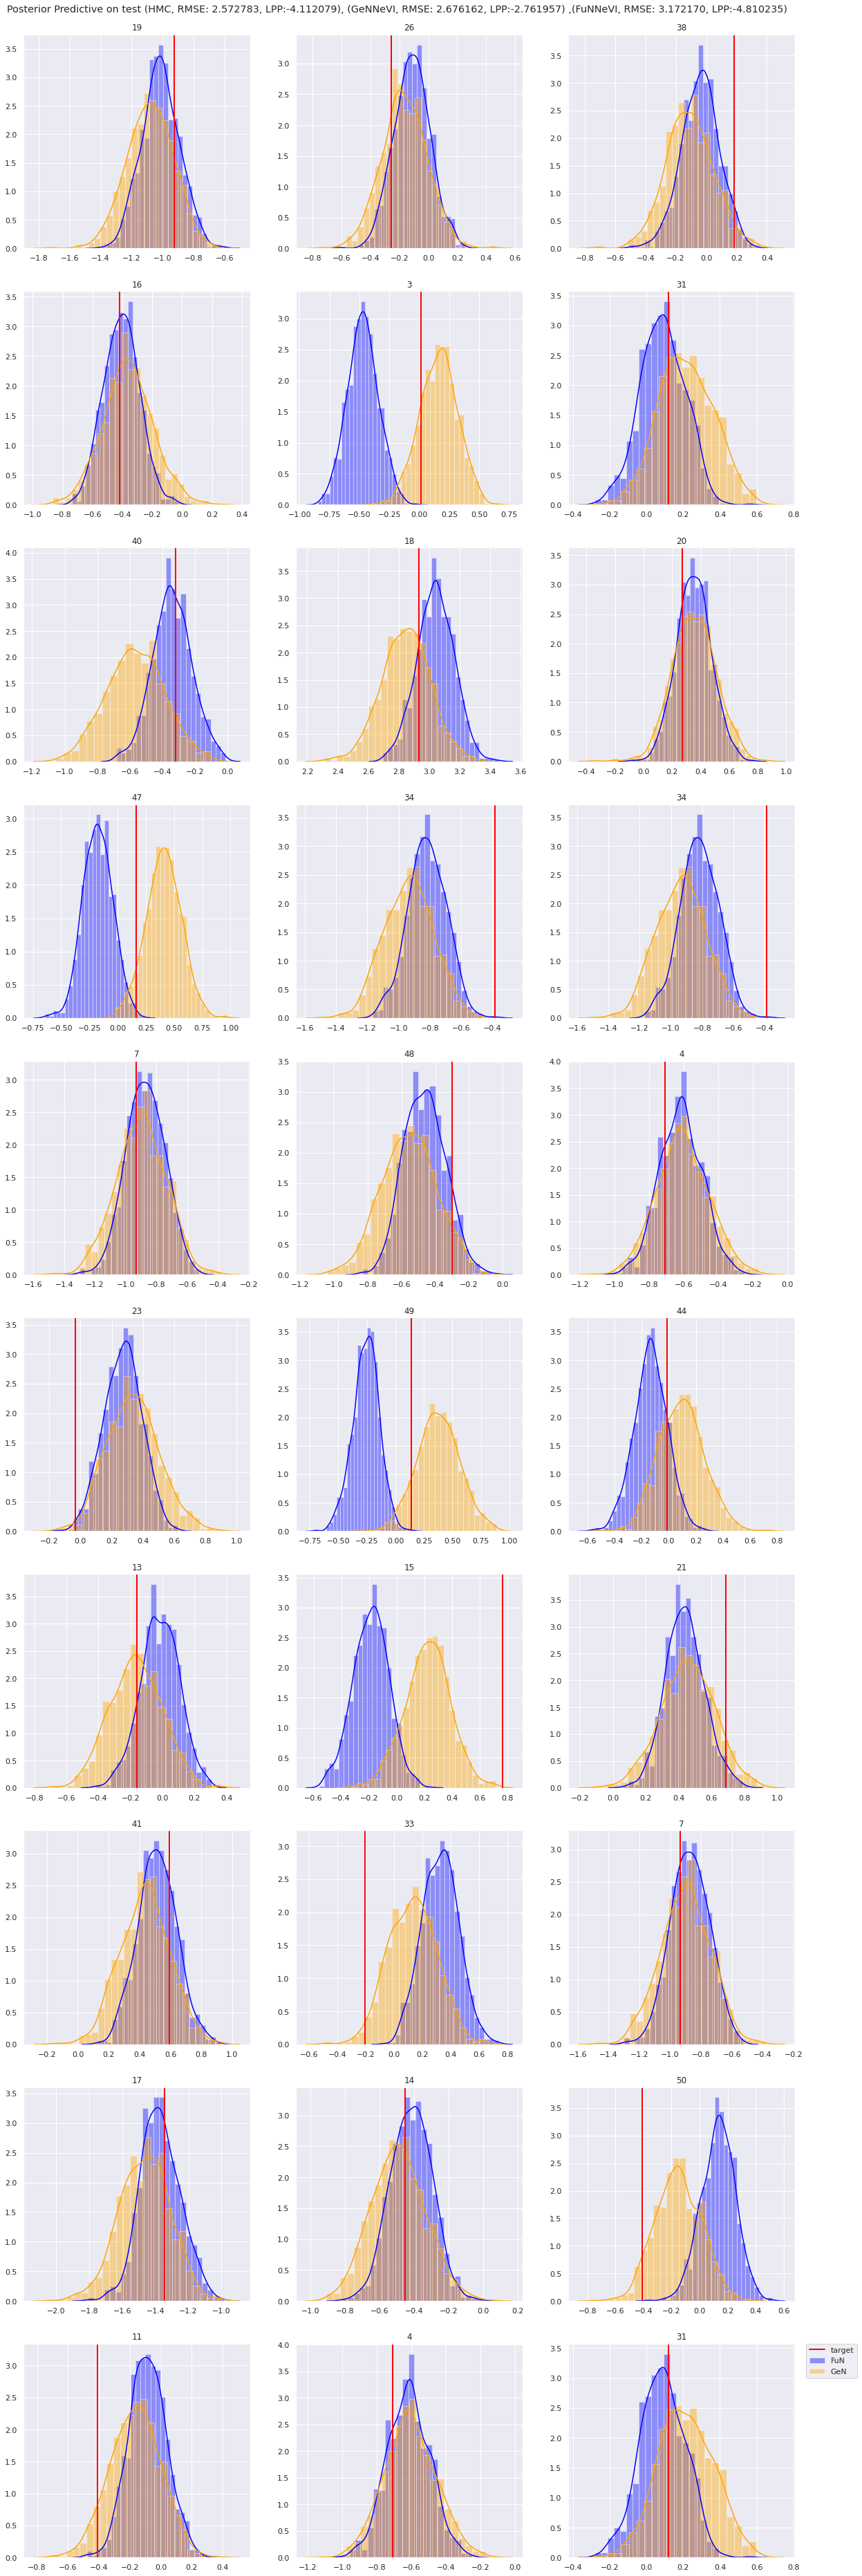

In [72]:
import seaborn as sns
from pylab import *
from Tools import log_norm



x_train, y_train=setup.train_data()
x_test, y_test=setup.test_data()
data='test'
if data=='test':
    x=x_test
if data=='OOD':
    x=ood_input(30)
    #x_train+0.05*torch.rand_like(x_train)##
y_pred_FuN=model(x, GeN_FuN(1000).detach())
y_pred_GeN=model(x, GeN_GeN(1000).detach())


def prior(n):
    return 0.5*torch.randn(size=(n,param_count), device=device)

pred_prior=model(x, prior(1000))
pred_GeN=y_pred_GeN+sigma_noise_GeN*torch.randn_like(y_pred_GeN)
pred_FuN=y_pred_FuN+sigma_noise_FuN*torch.randn_like(y_pred_FuN)

models_HMC = torch.load('Results/HMC_models.pt')
theta_HMC=models_HMC[dataset][:500,:].to(device)
pred_HMC = model(x,theta_HMC)
pred_HMC+=setup.sigma_noise*torch.randn_like(pred_HMC)



sns_plot=sns.set(rc={"figure.figsize": (20, 60)})
N=10
M=3
#np.random.seed(42)

for _ in range(1,1+N*M):
    i=np.random.randint(0,x.shape[0])
    subplot(N,M,_)
    #line4=plt.axvline(pred_FuN.mean(0)[i].cpu(), color='blue', lw=2.,label='mean FuN')
#    line4=plt.axvline(pred_GeN.mean(0)[i].cpu(), color='orange', lw=2.,label='mean GeN')

    ax =sns.distplot(pred_FuN[:,i].cpu(),label='FuN', color='blue')
    line5 =ax=sns.distplot(pred_GeN[:,i].cpu(),label='GeN', color='orange')
 #   line5 =sns.distplot(pred_prior[:,i].cpu(),label='prior', color='red')
#    ax=sns.distplot(pred_HMC[:,i].cpu(),label='HMC', color='gold')


    line1=plt.axvline(y_test[i].cpu(), color='red', linewidth=2.,label='target')


    plt.title(str(i))

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.subplots_adjust(top=.97)
plt.suptitle(t='Posterior Predictive on {} (HMC, RMSE: {:3f}, LPP:{:3f}), (GeNNeVI, RMSE: {:3f}, LPP:{:3f}) ,(FuNNeVI, RMSE: {:3f}, LPP:{:3f})'\
             .format(data, metrics_HMC[('HMC', 'RMSE')],metrics_HMC[('HMC', 'LPP')],\
                     metrics_GeN[('GeNNeVI', 'RMSE')],metrics_GeN[('GeNNeVI', 'LPP')],\
                     metrics_FuN[('FuNNeVI', 'RMSE')],metrics_FuN[('FuNNeVI', 'LPP')]))


In [ ]:
def BatchEntropy(theta,k=1,k_MC=1,device='cpu'):
    """
    Parameters:
        theta (Tensor): Samples, Batch x NbExemples X NbDimensions
        k (Int): ordinal number

    Returns:
        Tensor: H of size Batch x 1, k-Nearest Neighbour Estimation of the entropy of theta, H[b]=H(theta[b]).

    """
    batch=theta.shape[0]
    nb_samples=theta.shape[1]
    d=torch.tensor(theta.shape[-1]).float()
    D=torch.cdist(theta,theta)
    a = torch.topk(D, k=k+1, dim=1, largest=False, sorted=True)[0][:,k].to(device) #.clamp(torch.finfo().eps,float('inf'))    d=torch.as_tensor(float(dim), device=device)
    K=torch.as_tensor(float(k), device=device)
    K_MC=torch.as_tensor(float(k_MC), device=device)
    N=torch.as_tensor(float(nb_samples), device=device)
    pi=torch.as_tensor(math.pi, device=device)
    lcd = d/2.*pi.log() - torch.lgamma(1. + d/2.0)-d/2*K_MC.log()
    return torch.log(N) - torch.digamma(K) + lcd + d/nb_samples*torch.log(a).sum(1)

def EntropyScatterPlot(theta):
    X=[x_train,x_test,OOD_sampler(x_train,1000)]
    Y=[model(X[i],theta) for i in range(len(X))]
    H=[]
    for i in range(len(Y)):
        H.append(BatchEntropy(Y[i].transpose(0,1),k=len(Y[i])//100))
    return H


def EntropyScatterPlot(ax,theta,X, label, k,title):
    Y=[model(X[i],theta) for i in range(len(X))]
    for i in range(len(Y)):
        H=BatchEntropy(Y[i].transpose(0,1),k=k)
        ax=sns.distplot(H, label=label[i], ax=ax)
    ax.set_title(title)



x=x_test
x_ood=ood_input(500)
x_train_noisy=x_train+0.1*torch.rand_like(x_train)##
y_pred_FuN=model(x, GeN_FuN(1000).detach())
#y_pred_GeN=model(x, GeN_GeN(1000).detach())
X=[x_train,x_test,x_train_noisy,x_ood]
label=['train','test','noisy train', 'OOD']

def prior(n):
    return 0.5*torch.randn(size=(n,param_count), device=device)

fig,ax=plt.subplots(2,1,figsize=(10,10))

theta_FuN=GeN_FuN(1000).detach()
EntropyScatterPlot(ax[0],theta_FuN,X,label,100,'FuNNeVI')
theta_GeN=GeN_GeN(1000).detach()
EntropyScatterPlot(ax[1],theta_GeN,X,label,100,'GeNNeVI')
plt.legend()

fig.tight_layout()


In [34]:
def ensemble_bootstrap(dataset,device,seed):
    setup_ = get_setup(dataset)
    setup=setup_.Setup(device, seed=seed) 

    x_train, y_train=setup.train_data()
    x_test, y_test=setup.test_data()
#    torch.manual_seed(42)

    N = x_train.shape[0]
    input_dim=x_train.shape[1]
    model_list = []
      
    num_models=2 #10
    num_epochs=3000
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    size_data=len(train_dataset)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for m_i in range(num_models):
        
        model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, layerwidth),
            activation,
            torch.nn.Linear(layerwidth, 1))
        model.to(device)

        loss = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

        with trange(num_epochs) as tr:
            tr.set_description(desc=dataset+'/McDropout', refresh=False)
            for t in tr:
                cost = 0.
                count_batch=0
                for x,y in train_loader:
                    optimizer.zero_grad()
                    fx = model(x)
                    output = loss(fx, y)
                    output.backward()
                    optimizer.step()

                    cost += output.item() *len(x)
                    count_batch+=1
                tr.set_postfix(loss=cost/count_batch)              
        model_list.append(model)
   
    y_ts = [] 

    for m_i in range(len(model_list)):
        #Evaluate the model
        model_list[m_i].eval()
        y_ts.append(model_list[m_i](x_test).detach())

    y_t=torch.stack(y_ts, dim=0)
    y_t_mean = y_t.mean(axis=0)
    y_t_sigma = y_t.std(axis=0)

    return y_t_mean, y_t_sigma





In [35]:
ensemble_bootstrap('yacht',device,42)

yacht/McDropout: 100%|██████████| 3000/3000 [00:24<00:00, 124.92it/s, loss=0.0675]


(tensor([[-0.2850],
         [-0.2399],
         [-0.6660],
         [-0.6144],
         [ 0.6732],
         [-0.4680],
         [-0.3232],
         [-0.6813],
         [-0.4926],
         [-0.6035],
         [-0.5959],
         [-0.1684],
         [-0.7260],
         [ 0.5636],
         [-0.6223],
         [-0.1222],
         [-0.5887],
         [-0.6943],
         [ 0.2003],
         [-0.7148],
         [-0.6623],
         [-0.5173],
         [ 0.9205],
         [ 0.0980],
         [-0.5417],
         [-0.5743],
         [-0.6737],
         [-0.5653],
         [-0.3536],
         [ 2.2955],
         [ 0.0338]], device='cuda:0'),
 tensor([[7.9585e-03],
         [7.7439e-02],
         [1.5121e-03],
         [1.8435e-04],
         [1.0601e-01],
         [1.7530e-02],
         [9.7999e-03],
         [1.3769e-04],
         [2.7197e-02],
         [9.5849e-03],
         [9.8461e-03],
         [5.5003e-02],
         [7.6834e-05],
         [2.5610e-02],
         [4.6777e-03],
         [7.0404

In [41]:
if torch.ones(1,10,1) == 0.:
    print('True')
else:
    print('False')

RuntimeError: Boolean value of Tensor with more than one value is ambiguous